In [35]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

import xgboost as xgb
xgb.set_config(verbosity=1)

from util.Util import read_csv
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier



In [36]:
# Read GLOVE embeddings from file
glove_df = read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Reading CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:23, 80433.98it/s]


In [37]:
# Read the cleaned dataframe
full_df = read_csv('data/comparison_data/agnews_cleaned.csv')
full_df = full_df[(full_df['Rating'] == 1) | (full_df['Rating'] == 2)]
full_df['Rating'] = full_df['Rating'] - 1
full_df['NACE'] = 1111.0
full_df['id'] = range(len(full_df))
full_df = full_df.iloc[:500]

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description_no_stopwords'
vectorizer = TfidfVectorizer(max_features=250)
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col, verbose=False)

* Reading CSV from path: data/comparison_data/agnews_cleaned.csv. Size: (7190, 4)


In [38]:
full_df

,Rating,description,description_no_stopwords,description_no_stopwords_stemmed,NACE,id
20,1,michael phelps won the gold medal in the indiv...,michael phelps gold medal individual medley se...,michael phelp gold medal individu medley set w...,1111.0,0
21,1,in quot helping themselves quot ricky bryant c...,quot helping quot ricky bryant chas gessner mi...,quot help quot ricki bryant chas gessner micha...,1111.0,1
22,1,the cleveland indians pulled within one game o...,cleveland indians pulled within one game al ce...,cleveland indian pull within one game al centr...,1111.0,2
23,0,canadian press vancouver cp the sister of a ma...,canadian press vancouver cp sister man died vi...,canadian press vancouv cp sister man die viole...,1111.0,3
24,0,ap the man who claims gov james e mcgreevey se...,ap man claims gov james e mcgreevey sexually h...,ap man claim gov jame e mcgreevey sexual haras...,1111.0,4
...,...,...,...,...,...,...
894,1,sports network the kansas city royals try to g...,sports network kansas city royals try get back...,sport network kansa citi royal tri get back wi...,1111.0,495
895,1,sports network the montreal expos were handed ...,sports network montreal expos handed setback m...,sport network montreal expo hand setback monda...,1111.0,496
898,0,rebels struggle to make headway in talks aimin...,rebels struggle make headway talks aiming ease...,rebel struggl make headway talk aim eas confli...,1111.0,497
903,1,ap ron francis turned down a front office job ...,ap ron francis turned front office job carolin...,ap ron franci turn front offic job carolina hu...,1111.0,498


In [39]:
train_indices, test_indices = train_test_split(range(0,len(full_dff.documents())), test_size=0.33, random_state=42)

### Classify with tf-idf vectors

In [40]:
dfc = DataFrameClassifier(full_dff, glove_embeddings)

Initializing DataFrameFeatures object


In [41]:
X, y = dfc.get_tfidf_vectors()

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [42]:
clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)
clf.score(X_test,y_test)

0.9030303030303031

In [43]:
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='map')
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

0.793939393939394

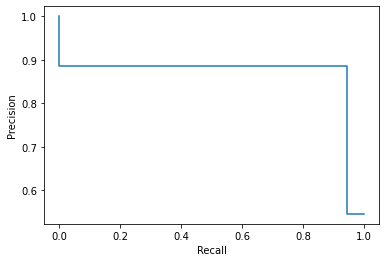

In [44]:
precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### Classify with feature vectors

In [45]:
X, y = dfc.get_feature_vectors()

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [46]:
clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7393939393939394

In [47]:
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='map')
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

0.7575757575757576

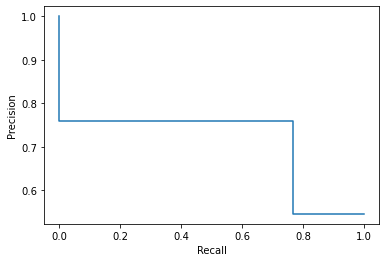

In [48]:
precision, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()